In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)

## 1. Load Data

In [2]:
# Regenerate features to ensure consistency with latest code
import src.features
import importlib
importlib.reload(src.features)
from src.features import extract_user_attributes, aggregate_user_features

print("Regenerating Training Features from Raw Data...")
# Load Raw Train Data
train_raw_path = '../data/train.parquet'
train_df_raw = pd.read_parquet(train_raw_path)

# Apply Feature Engineering
train_df_raw = extract_user_attributes(train_df_raw)
df = aggregate_user_features(train_df_raw)

print(f"Dataset Shape: {df.shape}")
print(f"Churn Rate: {df['target'].mean():.2%}")
df.head()

Regenerating Training Features from Raw Data...
Dataset Shape: (19140, 47)
Churn Rate: 22.31%
Dataset Shape: (19140, 47)
Churn Rate: 22.31%


,gender,level,platform,is_thumbs_up,is_thumbs_down,is_ad,is_error,is_song,length,downgrade,songs_last_1d,errors_last_1d,listen_time_last_1d,unique_artists_last_1d,unique_songs_last_1d,songs_last_3d,errors_last_3d,listen_time_last_3d,unique_artists_last_3d,unique_songs_last_3d,songs_last_7d,errors_last_7d,listen_time_last_7d,unique_artists_last_7d,unique_songs_last_7d,songs_last_14d,errors_last_14d,listen_time_last_14d,unique_artists_last_14d,unique_songs_last_14d,songs_last_30d,errors_last_30d,listen_time_last_30d,unique_artists_last_30d,unique_songs_last_30d,account_lifetime,avg_songs_per_day,thumbs_ratio,errors_per_song,trend_songs_7d_vs_30d,trend_listen_time_7d_vs_30d,total_sessions,avg_days_between_sessions,avg_songs_per_session,avg_session_duration,target,state_freq
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000025,M,paid,Windows,94,13,7,1,1662,417296.59169,0,212,0,52648.44590,197,208,535,1,132961.53374,440,502,687,1,173744.74643,552,645,1049,1,265573.95039,803,965,1662,1,417296.59169,1162,1468,100.460382,16.380778,0.870370,0.000601,1.653032,1.665430,17,5.909434,97.764706,24546.858335,1,0.012487
1000035,F,paid,Linux,117,15,6,1,1266,310364.86590,0,170,0,41213.98983,160,168,170,0,41213.98983,160,168,405,1,99705.54700,347,388,574,1,140551.62871,472,544,1133,1,278412.10335,835,1042,63.350567,19.673486,0.879699,0.000789,1.429328,1.432487,21,3.016694,60.285714,14779.279329,0,0.010972
1000083,M,paid,Windows,21,2,8,0,501,122606.27093,0,213,0,52170.90103,203,211,250,0,61312.53977,236,247,406,0,100331.33604,358,391,501,0,122606.27093,427,478,501,0,122606.27093,427,478,34.668854,14.045868,0.875000,0.000000,3.238931,3.273275,11,3.151714,45.545455,11146.024630,1,0.007524
1000103,F,paid,Linux,2,1,3,0,57,13554.73009,0,5,0,984.08263,5,5,5,0,984.08263,5,5,5,0,984.08263,5,5,18,0,3785.68327,18,18,18,0,3785.68327,18,18,47.459201,1.176247,0.500000,0.000000,1.086957,1.039684,3,15.819734,19.000000,4518.243363,0,0.031714
1000164,F,paid,Windows,38,6,20,1,847,209060.65753,0,184,0,42443.54099,173,183,216,0,50847.03993,202,215,313,0,75785.07918,286,306,479,1,117207.44962,400,450,513,1,126008.87092,426,480,99.147500,8.457525,0.844444,0.001179,2.438644,2.405699,15,6.609833,56.466667,13937.377169,0,0.021003


## 2. Preprocessing & Splitting

We will use a **Stratified Split** to maintain the churn ratio in both training and test sets.
We will also define a `ColumnTransformer` to handle:
- **Numerical Features**: Standard Scaling.
- **Categorical Features**: One-Hot Encoding.

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# 1. Separate Features and Target
# Check if 'userId' exists before dropping (it might be the index or already dropped)
X = df.drop(columns=["target"])
y = df['target']

# 2. Identify Column Types
# Categorical: 'gender', 'level', 'platform' (low cardinality)
# Note: 'state_freq' is numerical, so it goes to num_cols
categorical_cols = ['gender', 'level', 'platform']
numerical_cols = [c for c in X.columns if c not in categorical_cols]

print(f"Categorical Columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical Columns ({len(numerical_cols)}): {numerical_cols[:5]} ...")

# 3. Stratified Train-Test Split
# 20% Test, 80% Train
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)

print(f"\nTraining Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")
print(f"Train Churn Rate: {y_train.mean():.2%}")
print(f"Test Churn Rate: {y_test.mean():.2%}")

Categorical Columns (3): ['gender', 'level', 'platform']
Numerical Columns (43): ['is_thumbs_up', 'is_thumbs_down', 'is_ad', 'is_error', 'is_song'] ...

Training Shape: (15312, 46)
Test Shape: (3828, 46)
Train Churn Rate: 22.32%
Test Churn Rate: 22.31%


In [4]:
# 4. Define Preprocessing Pipeline
# We use a Pipeline to prevent data leakage (scaling parameters learned only on train)

# Numerical Transformer: Impute missing values with median, then scale
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical Transformer: Impute missing values with 'missing', then OneHotEncode
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ]
)

# Verify the pipeline works on training data
X_train_processed = preprocessor.fit_transform(X_train)
print(f"Processed Feature Matrix Shape: {X_train_processed.shape}")

Processed Feature Matrix Shape: (15312, 50)


## 3. Baseline Model Evaluation

We will evaluate the following industry-standard models:
1.  **Logistic Regression**: Simple baseline for interpretability.
2.  **Random Forest**: Robust bagging ensemble.
3.  **XGBoost**: Gradient boosting (often SOTA for tabular data).
4.  **LightGBM**: Faster and often more accurate gradient boosting.
5.  **CatBoost**: Excellent for categorical features (though we OHE them here).

**Metrics**:
- **F1-Score**: Harmonic mean of precision and recall (crucial for imbalanced churn).
- **ROC-AUC**: Ability to distinguish between classes.

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

# Define Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=RANDOM_SEED),
    # Removed use_label_encoder=False as it's deprecated and causing warnings
    "XGBoost": XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED),
    "LightGBM": LGBMClassifier(random_state=RANDOM_SEED, verbose=-1),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=RANDOM_SEED)
}

# Evaluation Function
def evaluate_models(models, X, y, preprocessor):
    results = []
    for name, model in models.items():
        # Create full pipeline
        clf = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', model)])
        
        # Cross-Validation (5-fold)
        # Added 'accuracy' to scoring
        cv_results = cross_validate(clf, X, y, cv=5, scoring=['f1', 'roc_auc', 'accuracy'])
        
        results.append({
            "Model": name,
            "F1 Score (Mean)": cv_results['test_f1'].mean(),
            "F1 Score (Std)": cv_results['test_f1'].std(),
            "ROC-AUC (Mean)": cv_results['test_roc_auc'].mean(),
            "ROC-AUC (Std)": cv_results['test_roc_auc'].std(),
            "Accuracy (Mean)": cv_results['test_accuracy'].mean(),
            "Accuracy (Std)": cv_results['test_accuracy'].std(),
            "CV F1 Scores": np.round(cv_results['test_f1'], 3) # Show individual scores
        })
        print(f"Evaluated {name}...")
        
    return pd.DataFrame(results).sort_values(by="F1 Score (Mean)", ascending=False)

# Run Evaluation
results_df = evaluate_models(models, X_train, y_train, preprocessor)
results_df

Evaluated Logistic Regression...
Evaluated Random Forest...
Evaluated Random Forest...
Evaluated XGBoost...
Evaluated XGBoost...
Evaluated LightGBM...
Evaluated LightGBM...
Evaluated CatBoost...
Evaluated CatBoost...


,Model,F1 Score (Mean),F1 Score (Std),ROC-AUC (Mean),ROC-AUC (Std),Accuracy (Mean),Accuracy (Std),CV F1 Scores
2,XGBoost,0.575951,0.019447,0.835011,0.004325,0.841823,0.005943,"[0.61, 0.582, 0.561, 0.572, 0.554]"
3,LightGBM,0.569702,0.021916,0.848570,0.004381,0.845806,0.006912,"[0.612, 0.57, 0.55, 0.559, 0.559]"
4,CatBoost,0.565439,0.023267,0.853275,0.004242,0.845676,0.007732,"[0.608, 0.574, 0.545, 0.552, 0.549]"
1,Random Forest,0.513672,0.018615,0.826586,0.005085,0.835096,0.005532,"[0.547, 0.52, 0.504, 0.496, 0.501]"
0,Logistic Regression,0.479536,0.006169,0.814243,0.008238,0.829219,0.002186,"[0.486, 0.475, 0.476, 0.488, 0.473]"


## 4. Hyperparameter Tuning

We will now optimize the hyperparameters for our top two performing models: **XGBoost** and **CatBoost**.
We use `RandomizedSearchCV` which is more efficient than Grid Search as it samples a fixed number of parameter settings from specified distributions.


In [6]:
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grids
xgb_params = {
    'classifier__n_estimators': [100, 200, 300, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5, 6, 8],
    'classifier__subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'classifier__gamma': [0, 0.1, 0.2, 0.5]
}

cat_params = {
    'classifier__iterations': [100, 200, 300, 500],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__depth': [4, 6, 8, 10],
    'classifier__l2_leaf_reg': [1, 3, 5, 7, 9]
}

# Helper function for tuning
def tune_model(model, params, X, y, preprocessor, n_iter=20):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    
    search = RandomizedSearchCV(
        pipeline, 
        param_distributions=params, 
        n_iter=n_iter, 
        scoring='f1', 
        cv=3, 
        verbose=1, 
        random_state=RANDOM_SEED, 
        n_jobs=-1
    )
    
    search.fit(X, y)
    return search

# Tune XGBoost
print("--- Tuning XGBoost ---")
xgb_model = XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED)
xgb_search = tune_model(xgb_model, xgb_params, X_train, y_train, preprocessor)

print(f"Best XGBoost F1: {xgb_search.best_score_:.4f}")
print(f"Best XGBoost Params: {xgb_search.best_params_}")

# Tune CatBoost
print("\n--- Tuning CatBoost ---")
cat_model = CatBoostClassifier(verbose=0, random_state=RANDOM_SEED)
cat_search = tune_model(cat_model, cat_params, X_train, y_train, preprocessor)

print(f"Best CatBoost F1: {cat_search.best_score_:.4f}")
print(f"Best CatBoost Params: {cat_search.best_params_}")


--- Tuning XGBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGBoost F1: 0.5692
Best XGBoost Params: {'classifier__subsample': 0.7, 'classifier__n_estimators': 300, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 1.0}

--- Tuning CatBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGBoost F1: 0.5692
Best XGBoost Params: {'classifier__subsample': 0.7, 'classifier__n_estimators': 300, 'classifier__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__gamma': 0.5, 'classifier__colsample_bytree': 1.0}

--- Tuning CatBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best CatBoost F1: 0.5692
Best CatBoost Params: {'classifier__learning_rate': 0.1, 'classifier__l2_leaf_reg': 5, 'classifier__iterations': 500, 'classifier__depth': 6}
Best CatBoost F1: 0.5692
Best CatBoost Params: {'classifier__learning_rate': 0.1, 'classifier__l2_leaf_reg': 

--- Tuning XGBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best XGBoost F1: 0.5699
Best XGBoost Params: {'classifier__subsample': 0.9, 'classifier__n_estimators': 500, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.2, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.9}


--- Tuning CatBoost ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best CatBoost F1: 0.5661
Best CatBoost Params: {'classifier__learning_rate': 0.1, 'classifier__l2_leaf_reg': 5, 'classifier__iterations': 500, 'classifier__depth': 6}

## 5. Ensemble Modeling (Stacking)

We will now combine our tuned **XGBoost** and **CatBoost** models using a `StackingClassifier`.
This technique uses a meta-model (Logistic Regression) to learn the best combination of the base models' predictions.
We use the optimal hyperparameters found in the previous step.

In [7]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate


# 1. Retrieve Best Models from Search

# # 1. Define Tuned Models with Hardcoded Parameters
# best_xgb_params = {
#     'n_estimators': 500,
#     'learning_rate': 0.2,
#     'max_depth': 6,
#     'subsample': 0.9,
#     'colsample_bytree': 0.9,
#     'gamma': 0.1,
#     'eval_metric': 'logloss',
#     'random_state': RANDOM_SEED
# }

# best_cat_params = {
#     'iterations': 500,
#     'learning_rate': 0.1,
#     'depth': 6,
#     'l2_leaf_reg': 5,
#     'verbose': 0,
#     'random_state': RANDOM_SEED
# }

# best_xgb = XGBClassifier(**best_xgb_params)
# best_cat = CatBoostClassifier(**best_cat_params)

best_xgb = xgb_search.best_estimator_.named_steps["classifier"]  # type: ignore
best_cat = cat_search.best_estimator_.named_steps["classifier"]  # type: ignore

# 2. Create Stacking Ensemble
# We wrap each base model in the preprocessor pipeline so they can handle the raw data
estimators = [
    ('xgb', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_xgb)])),
    ('cat', Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_cat)]))
]

# The final estimator uses the predictions of the base estimators
# We use Logistic Regression as the meta-learner
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(random_state=RANDOM_SEED),
    cv=5,
    n_jobs=-1
)

# 3. Evaluate Stacking Model
print("Evaluating Stacking Classifier (this may take a moment)...")
cv_results_stack = cross_validate(stacking_clf, X_train, y_train, cv=5, scoring=['f1', 'roc_auc', 'accuracy'])

print(f"Stacking F1 Score: {cv_results_stack['test_f1'].mean():.4f} (+/- {cv_results_stack['test_f1'].std():.4f})")
print(f"Stacking ROC-AUC: {cv_results_stack['test_roc_auc'].mean():.4f}")
print(f"Stacking Accuracy: {cv_results_stack['test_accuracy'].mean():.4f}")

Evaluating Stacking Classifier (this may take a moment)...
Stacking F1 Score: 0.5884 (+/- 0.0216)
Stacking ROC-AUC: 0.8532
Stacking Accuracy: 0.8491
Stacking F1 Score: 0.5884 (+/- 0.0216)
Stacking ROC-AUC: 0.8532
Stacking Accuracy: 0.8491


## 6. Threshold Optimization

Standard models use a default threshold of 0.5 to classify a user as "Churn" or "Not Churn".
However, since our dataset is imbalanced and we care deeply about F1-Score, this default is rarely optimal.

We will:
1.  Generate probability predictions using Cross-Validation (to avoid overfitting).
2.  Iterate through all possible thresholds (0.01 to 0.99).
3.  Find the threshold that maximizes the F1-Score.

Generating cross-validated predictions...
Optimal Threshold: 0.23
Max Cross-Validated F1 Score: 0.6281
Optimal Threshold: 0.23
Max Cross-Validated F1 Score: 0.6281


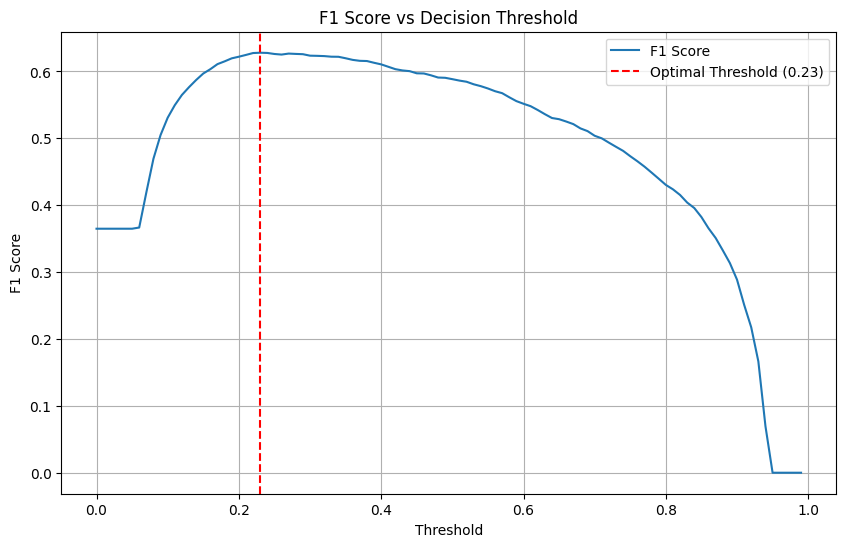

In [8]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import f1_score

# 1. Get probability predictions via Cross-Validation
# This ensures we don't overfit the threshold to the training data
print("Generating cross-validated predictions...")
y_scores = cross_val_predict(stacking_clf, X_train, y_train, cv=5, method='predict_proba')[:, 1]

# 2. Find Optimal Threshold
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for thresh in thresholds:
    y_pred_thresh = (y_scores >= thresh).astype(int)
    f1_scores.append(f1_score(y_train, y_pred_thresh))

optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]
max_f1_score = f1_scores[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Max Cross-Validated F1 Score: {max_f1_score:.4f}")

# Plot F1 vs Threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1 Score')
plt.axvline(optimal_threshold, color='r', linestyle='--', label=f'Optimal Threshold ({optimal_threshold:.2f})')
plt.title('F1 Score vs Decision Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

## 7. Final Evaluation on Test Set

Now we perform the final "exam". We will:
1.  Retrain the Stacking Model on the **full training set**.
2.  Predict probabilities on the **held-out test set**.
3.  Apply our **Optimal Threshold** to generate final class predictions.
4.  Report the final performance metrics.

Retraining Stacking Model on full training set...

--- Final Test Set Performance ---
ROC-AUC: 0.8497

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2974
           1       0.59      0.66      0.62       854

    accuracy                           0.82      3828
   macro avg       0.74      0.76      0.75      3828
weighted avg       0.83      0.82      0.83      3828


--- Final Test Set Performance ---
ROC-AUC: 0.8497

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      2974
           1       0.59      0.66      0.62       854

    accuracy                           0.82      3828
   macro avg       0.74      0.76      0.75      3828
weighted avg       0.83      0.82      0.83      3828



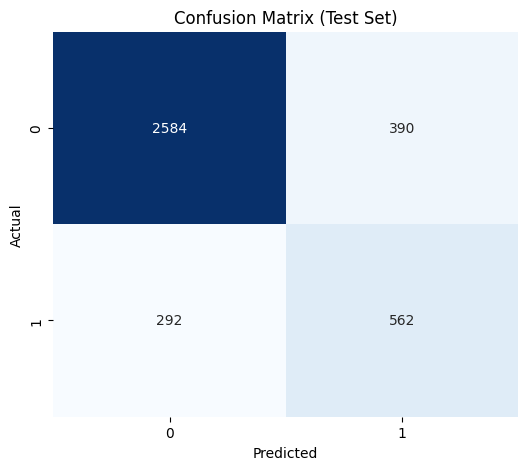

In [9]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 1. Retrain on Full Training Set
print("Retraining Stacking Model on full training set...")
stacking_clf.fit(X_train, y_train)

# 2. Predict on Test Set
y_test_probs = stacking_clf.predict_proba(X_test)[:, 1]  # type: ignore
y_test_pred = (y_test_probs >= optimal_threshold).astype(int)

# 3. Final Metrics
print("\n--- Final Test Set Performance ---")
print(f"ROC-AUC: {roc_auc_score(y_test, y_test_probs):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Test Set)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## 8. Generate Submission File

We will now generate predictions for the **Test Dataset** (`data/test.parquet`).
Since this is likely raw data, we need to apply the same **Feature Engineering** steps as we did for the training data.

**Steps**:
1.  Load `test.parquet`.
2.  Apply `extract_user_attributes` and `aggregate_user_features`.
3.  Generate probabilities using the trained `stacking_clf`.
4.  Apply the `optimal_threshold`.
5.  Save to `submission.csv`.

In [10]:
import importlib
import src.features
importlib.reload(src.features)
from src.features import extract_user_attributes, aggregate_user_features

# 1. Load Raw Test Data
test_data_path = '../data/test.parquet'
print(f"Loading test data from {test_data_path}...")
test_df_raw = pd.read_parquet(test_data_path)

# 2. Apply Feature Engineering
print("Applying feature engineering...")
test_df_raw = extract_user_attributes(test_df_raw)
test_features = aggregate_user_features(test_df_raw)

# Drop 'target' if it exists (it's created by aggregate_user_features as 0s)
if 'target' in test_features.columns:
    test_features = test_features.drop(columns=['target'])

# Ensure columns match training data
# We align the test features to the training features (filling missing with 0, dropping extras)
# Note: X_train columns are the reference
missing_cols = set(X_train.columns) - set(test_features.columns)
for c in missing_cols:
    test_features[c] = 0

# Reorder columns to match X_train
test_features = test_features[X_train.columns]

print(f"Test Features Shape: {test_features.shape}")

# 3. Generate Predictions
print("Generating predictions...")
test_probs = stacking_clf.predict_proba(test_features)[:, 1]  # type: ignore
test_preds = (test_probs >= optimal_threshold).astype(int)

# 4. Create Submission DataFrame
submission_df = pd.DataFrame({
    'id': test_features.index,
    'target': test_preds
})

# 5. Save to CSV
submission_path = '../data/submission.csv'
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")
print(submission_df.head())

Loading test data from ../data/test.parquet...
Applying feature engineering...
Applying feature engineering...
Test Features Shape: (2904, 46)
Generating predictions...
Submission saved to ../data/submission.csv
        id  target
0  1000655       0
1  1000963       1
2  1001129       0
3  1001963       1
4  1002283       0
Test Features Shape: (2904, 46)
Generating predictions...
Submission saved to ../data/submission.csv
        id  target
0  1000655       0
1  1000963       1
2  1001129       0
3  1001963       1
4  1002283       0


**Submit Command Line**: `kaggle competitions submit -c churn-prediction-25-26 -f Project/data/submission.csv -m "Raynor X Attempt"`


In [12]:
# --- SAVE MODEL ARTIFACTS ---
import joblib
import os

# Create models directory if it doesn't exist
models_dir = '../models'
os.makedirs(models_dir, exist_ok=True)

print(f"Saving artifacts to {models_dir}...")

# 1. Save the Stacking Model
model_path = os.path.join(models_dir, 'stacking_model.joblib')
joblib.dump(stacking_clf, model_path)
print(f"- Model saved to {model_path}")

# 2. Save the Preprocessor
preprocessor_path = os.path.join(models_dir, 'preprocessor.joblib')
joblib.dump(preprocessor, preprocessor_path)
print(f"- Preprocessor saved to {preprocessor_path}")

# 3. Save the Optimal Threshold
threshold_path = os.path.join(models_dir, 'optimal_threshold.joblib')
joblib.dump(optimal_threshold, threshold_path)
print(f"- Optimal Threshold ({optimal_threshold:.4f}) saved to {threshold_path}")

# 4. Save Feature Names (Crucial for alignment)
features_path = os.path.join(models_dir, 'feature_names.joblib')
joblib.dump(X_train.columns, features_path)
print(f"- Feature names saved to {features_path}")


Saving artifacts to ../models...
- Model saved to ../models/stacking_model.joblib
- Preprocessor saved to ../models/preprocessor.joblib
- Optimal Threshold (0.2300) saved to ../models/optimal_threshold.joblib
- Feature names saved to ../models/feature_names.joblib
